In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os, sys
from tqdm import tqdm, trange
from einops import rearrange

sys.path.append("../")
from models import utils
from models import neural_fields, bfield
from models import explicit
from models.plot_params import set_params
set_params()

%load_ext autoreload
%autoreload 2

## Spatial regularization & optimization

In [ ]:
# Readind the data:
import astropy.io.fits as fits

datadir = "plage_sst/"
img = np.ascontiguousarray(
    fits.open(datadir + "CRISP_5173_plage_dat.fits", "readonly")[0].data,
    dtype="float32",
)
xl = np.ascontiguousarray(
    fits.open(datadir + "CRISP_5173_plage_wav.fits", "readonly")[0].data,
    dtype="float32",
)
ny, nx, nStokes, nWav = img.shape

In [3]:
# Model
niter = 200
mymodel = bfield.WFA_model3D(img,xl,mask=[5,6,7], spectral_line=5173)

# Spatial regularization:
reguV=1e-4
reguQU=1e-2

# Initial guess
B0, B1, B2 = mymodel.initial_guess(inner=False, split=True)



Data: torch.Size([200, 178, 4, 13]) should be in the format [(nt) ny nx ns nw]
Wav: (13,) should be in Angstroms relative to the center of the line
mask: [5, 6, 7] are the indices to use during the optimization


In [4]:
out = torch.ones(nx*ny, 3)
# Get initial guess for the first time step and expand
B0_exp, BtQ_exp, BtU_exp = mymodel.initial_guess(inner=True, split=True) # These are already (ny*nx, nTime)

out[:, 0] = B0_exp / 1e3 # Blos
out[:, 1] = (BtQ_exp / 1e6) # BQ (from Bt and phiB in forward)
out[:, 2] = (BtU_exp / 1e6) # BU (from Bt and phiB in forward)

# Make the parameters differentiable
out.requires_grad = True


optimizer = torch.optim.Adam([out], lr=1e-2)

outplot, out = explicit.optimization(optimizer=optimizer,niterations=niter, parameters=out,model=mymodel, reguV=reguV, reguQU=reguQU, weights=[10,10,10], normgrad=True)


100%|██████████| 200/200 [00:12<00:00, 15.98it/s, total=0.262, chi2=0.258, spatial=0.00369, temporal=0]


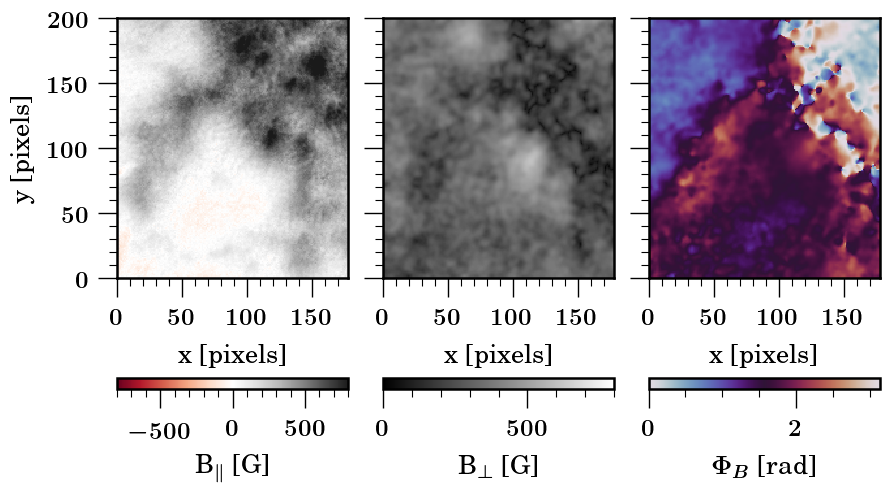

In [14]:
# Plots
Blos, Bhor, Bazi = outplot[:,:,0,0], outplot[:,:,0,1], outplot[:,:,0,2]
plt.close("all");
extent = np.float64((0,nx,0,ny))
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,7))
im0 = ax[0].imshow(Blos*1000.0, vmax=800, vmin=-800, cmap='RdGy',      interpolation='nearest', extent=extent)
im1 = ax[1].imshow(Bhor*1000.0, vmin=0, vmax=800,   cmap='gist_gray', interpolation='nearest', extent=extent)
im2 = ax[2].imshow(Bazi, vmax=np.pi, vmin=0,    cmap='twilight',      interpolation='nearest', extent=extent)

names = [r'B$_\parallel$', r'B$_\bot$', r'$\Phi_B$']
f.colorbar(im0, ax=ax[0], orientation='horizontal', label=names[0]+' [G]')
f.colorbar(im1, ax=ax[1], orientation='horizontal', label=names[1]+' [G]')
f.colorbar(im2, ax=ax[2], orientation='horizontal', label=names[2]+' [rad]')

for ii in range(1,3):
    ax[ii].set_yticklabels([])
for ii in range(3):
    ax[ii].set_xlabel('x [pixels]')
    ax[ii].minorticks_on()
    ax[ii].locator_params(axis='x', nbins=5)
    ax[ii].locator_params(axis='y', nbins=5)
ax[0].set_ylabel('y [pixels]')
f.set_tight_layout(True)

for cbar in f.get_axes():
    cbar.minorticks_on() # Minorticks in the colorbar:


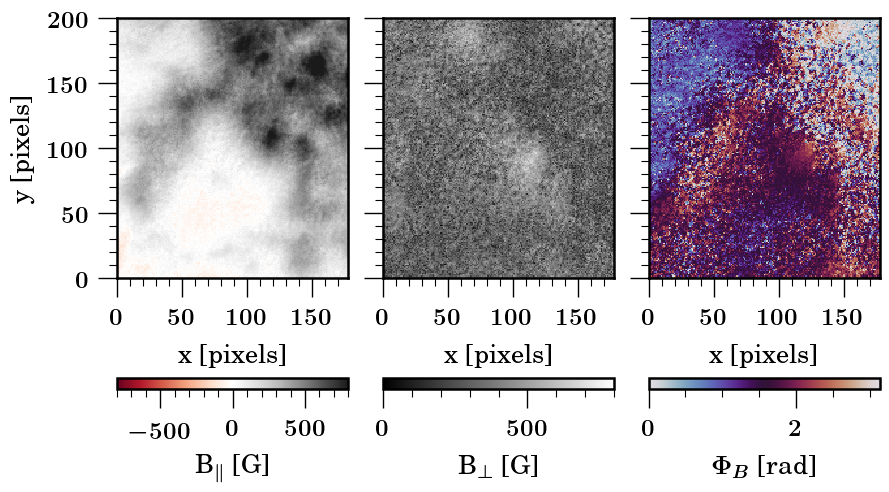

In [16]:
# Plots
plt.close("all");
extent = np.float64((0,nx,0,ny))
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,7))
im0 = ax[0].imshow(B0.reshape(ny,nx), vmax=800, vmin=-800, cmap='RdGy',      interpolation='nearest', extent=extent)
im1 = ax[1].imshow(B1.reshape(ny,nx), vmin=0, vmax=800,   cmap='gist_gray', interpolation='nearest', extent=extent)
im2 = ax[2].imshow(B2.reshape(ny,nx), vmax=np.pi, vmin=0,    cmap='twilight',      interpolation='nearest', extent=extent)

names = [r'B$_\parallel$', r'B$_\bot$', r'$\Phi_B$']
f.colorbar(im0, ax=ax[0], orientation='horizontal', label=names[0]+' [G]')
f.colorbar(im1, ax=ax[1], orientation='horizontal', label=names[1]+' [G]')
f.colorbar(im2, ax=ax[2], orientation='horizontal', label=names[2]+' [rad]')

for ii in range(1,3):
    ax[ii].set_yticklabels([])
for ii in range(3):
    ax[ii].set_xlabel('x [pixels]')
    ax[ii].minorticks_on()
    ax[ii].locator_params(axis='x', nbins=5)
    ax[ii].locator_params(axis='y', nbins=5)
ax[0].set_ylabel('y [pixels]')
f.set_tight_layout(True)


for cbar in f.get_axes():
    cbar.minorticks_on() # Minorticks in the colorbar:
